# Model

Fire detection using VGG16 refers to a method of identifying and detecting fires in images or video frames using the VGG16 convolutional neural network (CNN) architecture. VGG16 is a popular CNN model that has been widely used for various computer vision tasks, including image classification.

In [1]:
import os
import cv2
from tqdm import tqdm
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import keras 
from keras.callbacks import EarlyStopping,ModelCheckpoint
import tensorflow as tf
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import warnings
warnings.filterwarnings('ignore')

In [2]:
#Files
path=r'C:\Users\AL-FAJR\Desktop\New folder (3)\Last_GP\GP_Model\fire_dataset'
pd.DataFrame(os.listdir(path),columns=['Files'])

Files
0      fire_images
1  non_fire_images

In [4]:
train_data_dir =path
batch_size = 32
target_size = (224, 224)
validation_split = 0.2
train= tf.keras.preprocessing.image_dataset_from_directory(
    train_data_dir,
    validation_split=validation_split,
    subset="training",
    seed=200,
    image_size=target_size,
    batch_size=batch_size,
)
validation= tf.keras.preprocessing.image_dataset_from_directory(
    train_data_dir,
    validation_split=validation_split,
    subset="validation",
    seed=44,
    image_size=target_size,
    batch_size=batch_size,
)

Found 1787 files belonging to 2 classes.
Using 1430 files for training.
Found 1787 files belonging to 2 classes.
Using 357 files for validation.


In [5]:
class_names = train.class_names
class_names

['fire_images', 'non_fire_images']

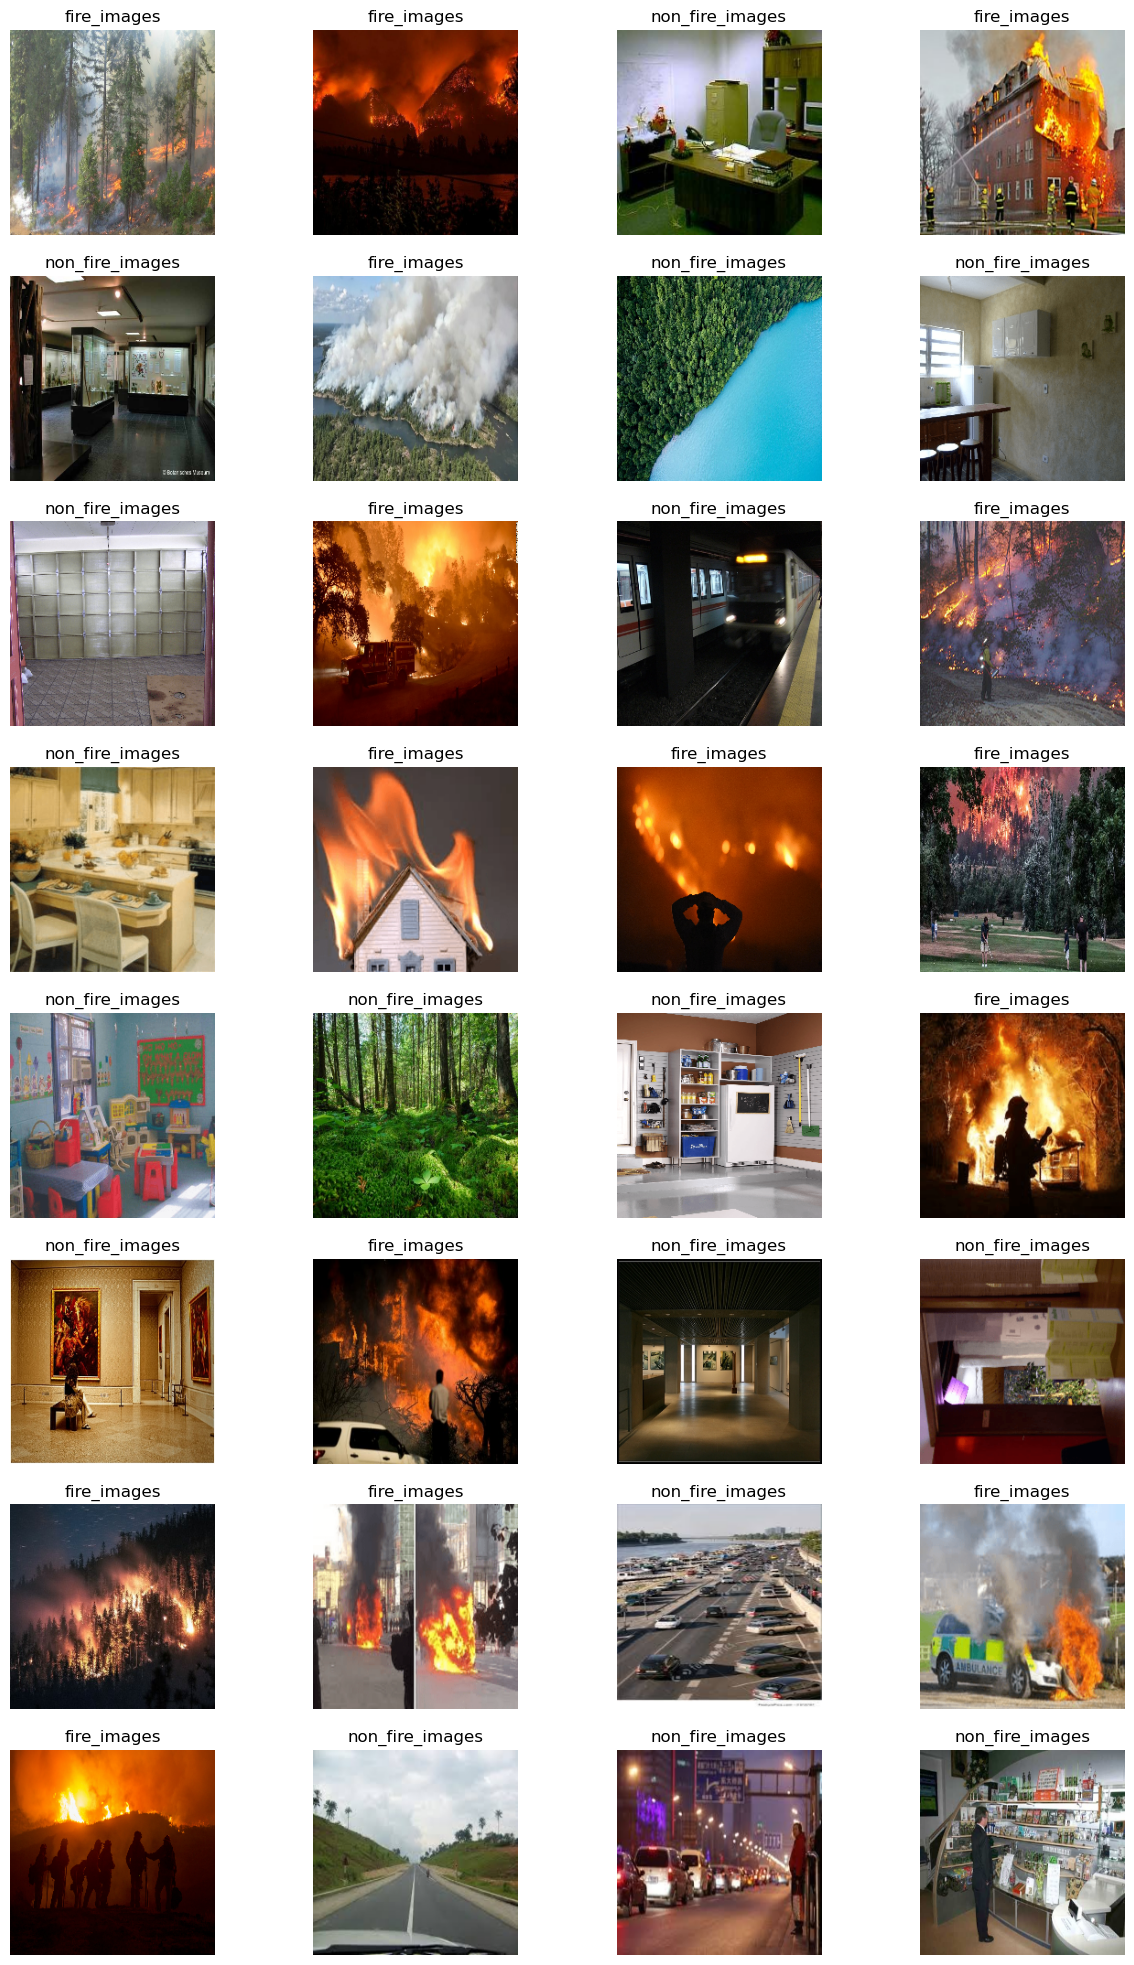

In [6]:
plt.figure(figsize=(15, 25))
for images, labels in train.take(1):
    for i in range(32):
        ax = plt.subplot(8, 4, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dropout (Dropout)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 1)                 25089     
                                                                 
Total params: 14,739,777
Trainable params: 25,089
Non-trainable params: 14,714,688
_________________________________________________________________


In [8]:
tf.keras.utils.plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True,show_dtype=True,dpi=120)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [9]:
checkpoint_cb =ModelCheckpoint("my_keras_model.h5", save_best_only=True)
early_stopping_cb =EarlyStopping(patience=3, restore_best_weights=True)
model.compile(optimizer ='adam',loss='binary_crossentropy', metrics=['accuracy'])
hist=model.fit_generator(train,epochs=20,validation_data=validation,callbacks=[checkpoint_cb,early_stopping_cb])

Epoch 1/20
45/45 [==============================] - 304s 7s/step - loss: 1.7216 - accuracy: 0.8944 - val_loss: 0.2374 - val_accuracy: 0.9664
Epoch 2/20
45/45 [==============================] - 311s 7s/step - loss: 0.1958 - accuracy: 0.9818 - val_loss: 0.1928 - val_accuracy: 0.9776
Epoch 3/20
45/45 [==============================] - 302s 7s/step - loss: 0.0792 - accuracy: 0.9902 - val_loss: 0.2556 - val_accuracy: 0.9776
Epoch 4/20
45/45 [==============================] - 305s 7s/step - loss: 0.0703 - accuracy: 0.9944 - val_loss: 0.2387 - val_accuracy: 0.9804
Epoch 5/20
45/45 [==============================] - 300s 7s/step - loss: 0.0549 - accuracy: 0.9937 - val_loss: 0.3933 - val_accuracy: 0.9776


In [10]:
# Accessing training and validation accuracy
training_accuracy = hist.history['accuracy']
validation_accuracy = hist.history['val_accuracy']



In [11]:
training_accuracy[-1]

0.9937062859535217

In [12]:
score, acc = model.evaluate(validation)
print('Test Loss =', score)
print('Test Accuracy =', acc)

12/12 [==============================] - 60s 5s/step - loss: 0.1928 - accuracy: 0.9776
Test Loss = 0.192830890417099
Test Accuracy = 0.9775910377502441


In [13]:
hist_=pd.DataFrame(hist.history)
hist_

loss  accuracy  val_loss  val_accuracy
0  1.721579  0.894406  0.237383      0.966387
1  0.195817  0.981818  0.192831      0.977591
2  0.079249  0.990210  0.255621      0.977591
3  0.070261  0.994406  0.238733      0.980392
4  0.054940  0.993706  0.393251      0.977591

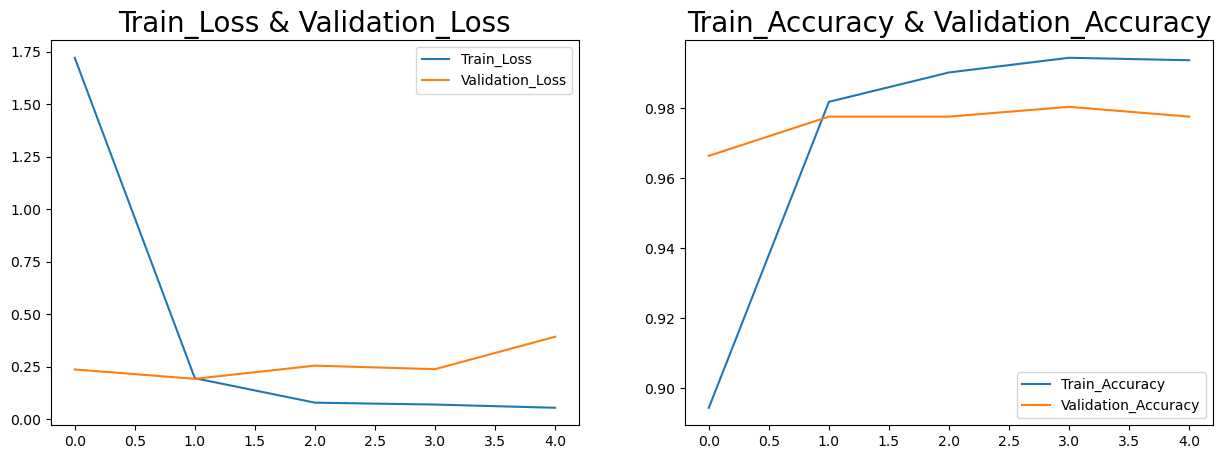

In [14]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(hist_['loss'],label='Train_Loss')
plt.plot(hist_['val_loss'],label='Validation_Loss')
plt.title('Train_Loss & Validation_Loss',fontsize=20)
plt.legend()
plt.subplot(1,2,2)
plt.plot(hist_['accuracy'],label='Train_Accuracy')
plt.plot(hist_['val_accuracy'],label='Validation_Accuracy')
plt.title('Train_Accuracy & Validation_Accuracy',fontsize=20)
plt.legend()

In [15]:
X_val,y_val=[],[]
for images, labels in validation:
    y_val.extend(labels.numpy())
    X_val.extend(images.numpy())
predictions=model.predict(np.array(X_val))
y_pred=np.where(predictions>=.5,1,0)
df=pd.DataFrame()
df['Actual'],df['Prediction']=y_val,y_pred
df

12/12 [==============================] - 58s 5s/step


Actual  Prediction
0         1           1
1         0           0
2         1           1
3         0           0
4         0           0
..      ...         ...
352       0           0
353       1           1
354       0           0
355       0           0
356       0           0

[357 rows x 2 columns]

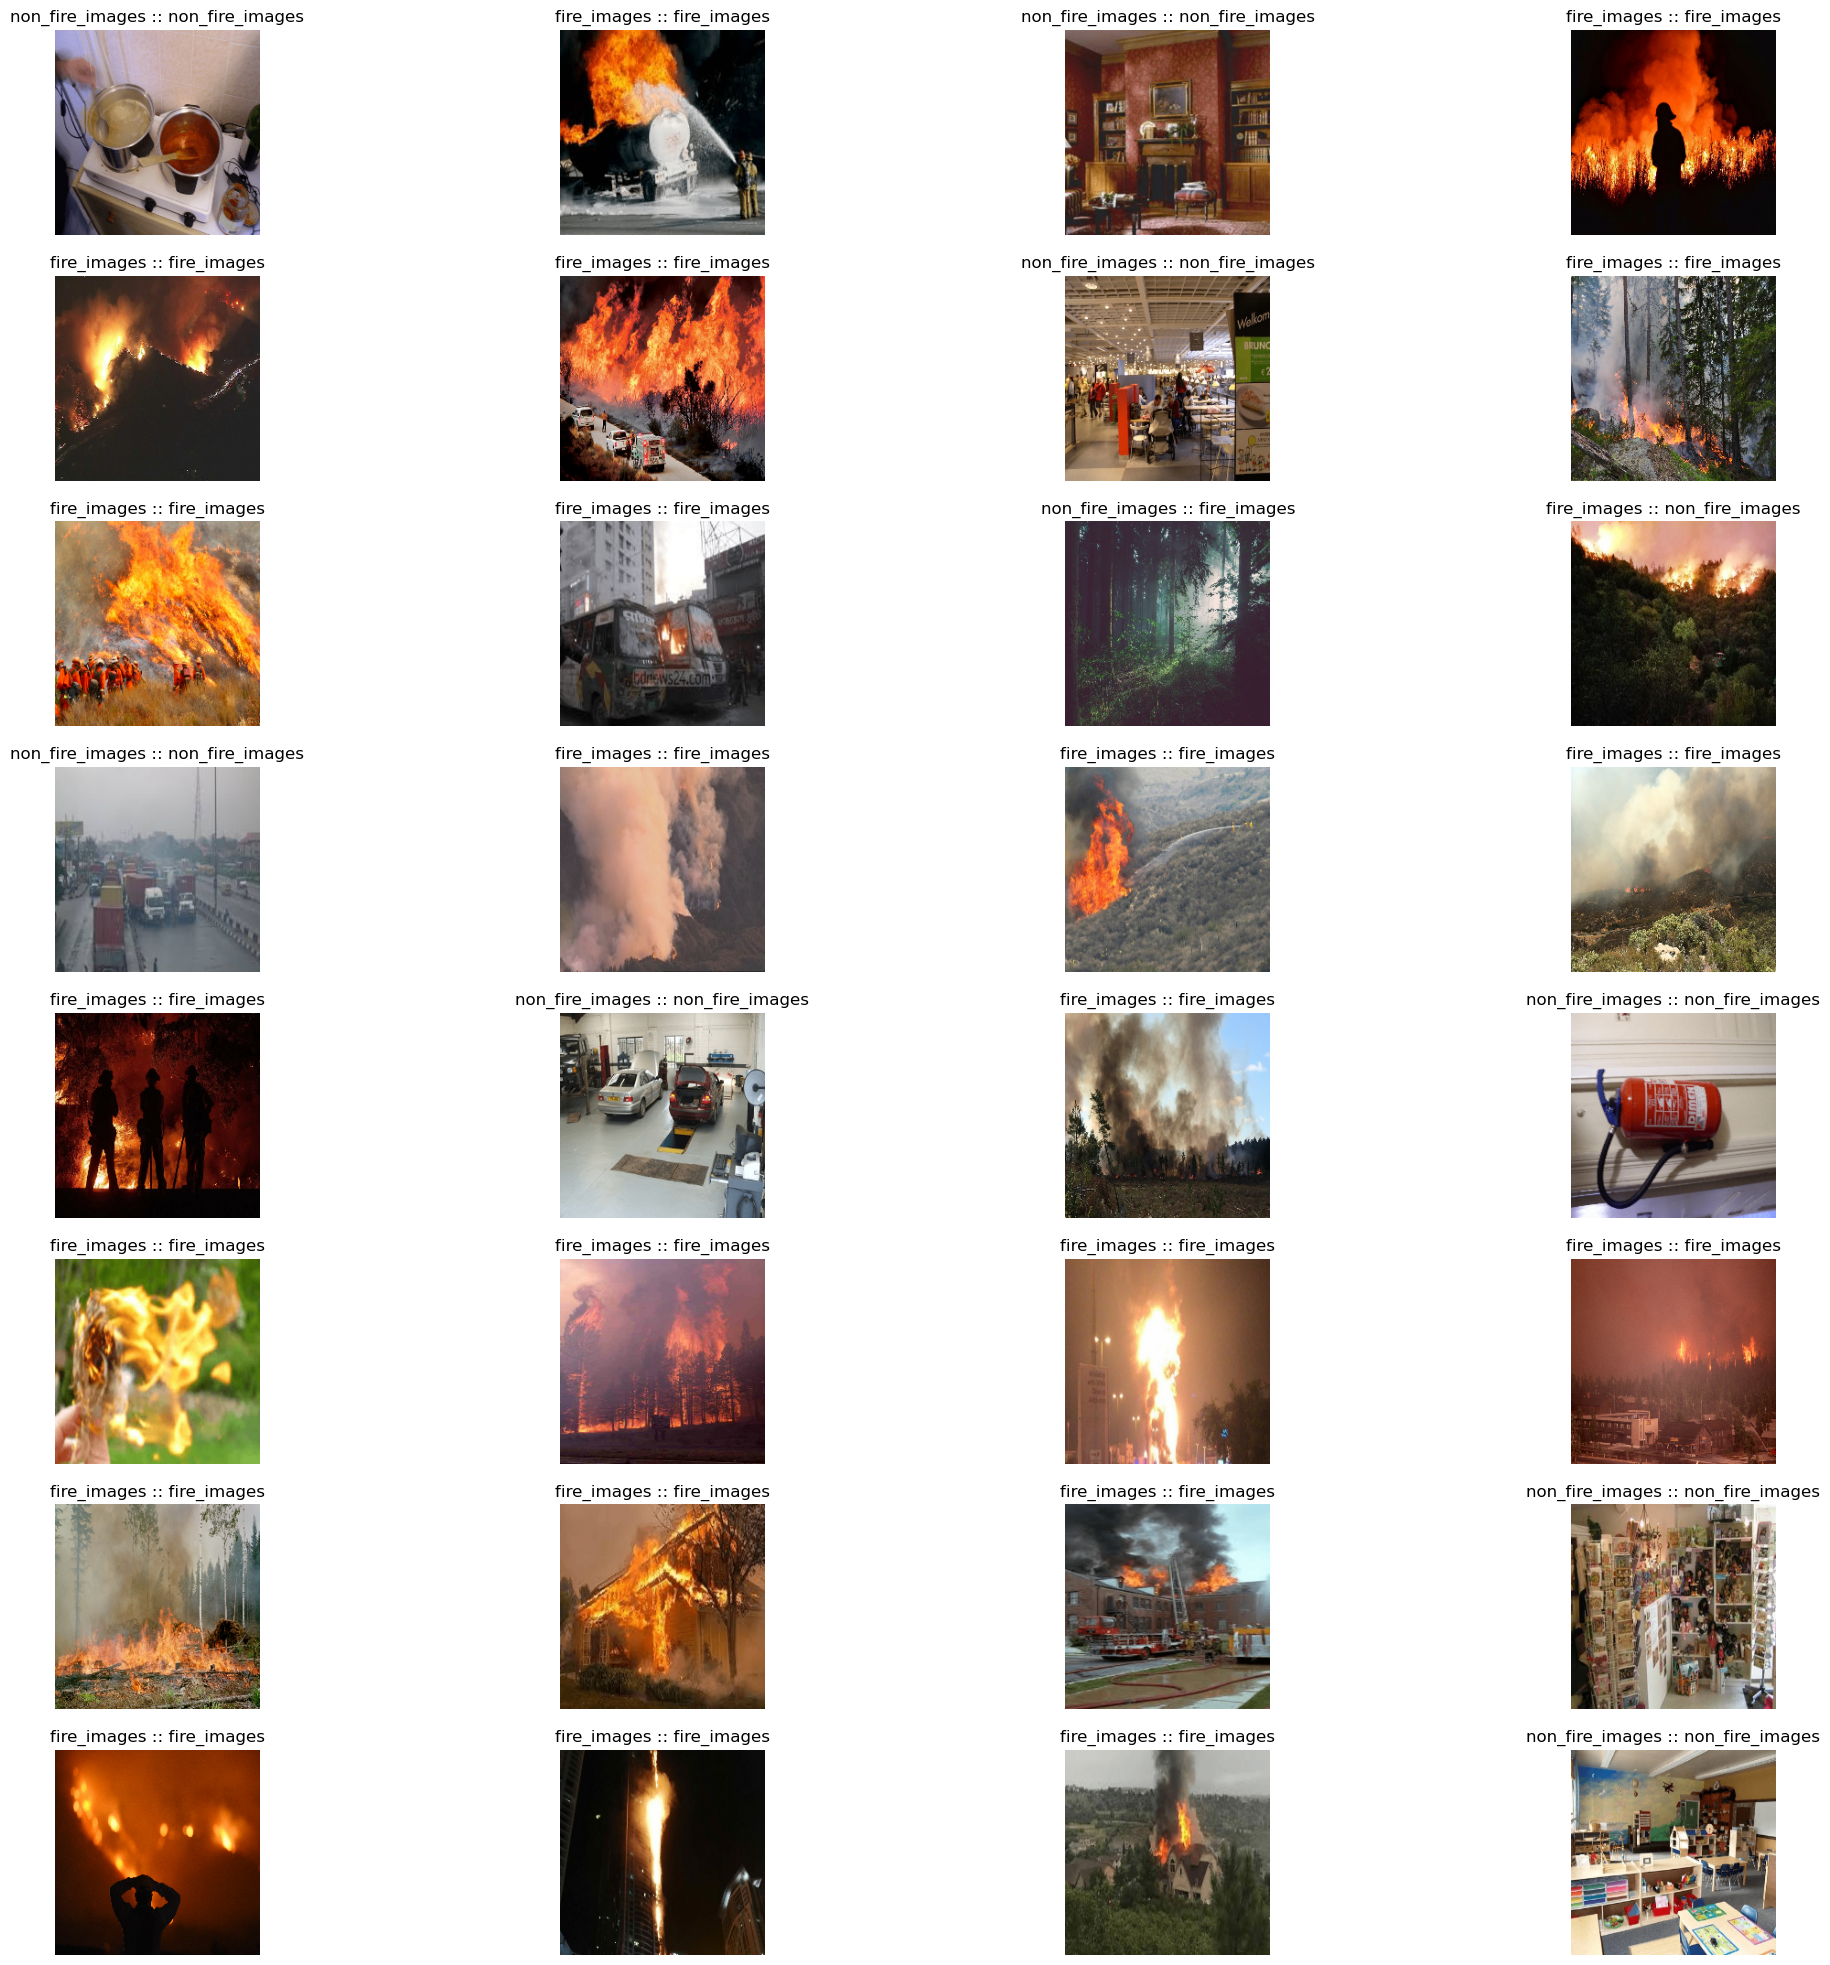

In [16]:
plt.figure(figsize=(25,25))
for i in range(32):
    ax = plt.subplot(8, 4, i + 1)
    plt.imshow(X_val[i].astype("uint8"))
    plt.title(f'{class_names[y_val[i]]} :: {class_names[y_pred[i][0]]}')
    plt.axis("off")

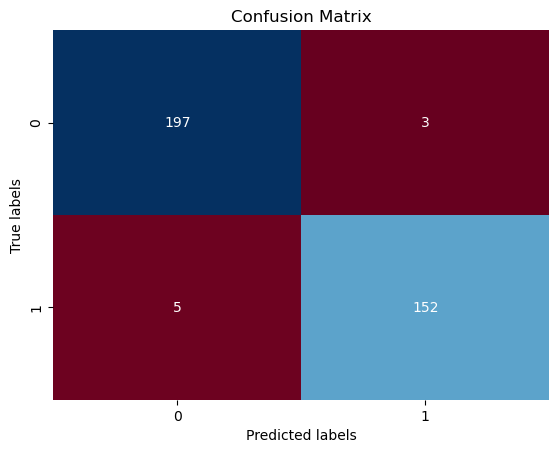

array([[197,   3],
       [  5, 152]], dtype=int64)

In [17]:
ax= plt.subplot()
CM = confusion_matrix(y_val,y_pred)
sns.heatmap(CM, annot=True, fmt='g', ax=ax,cbar=False,cmap='RdBu')
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels') 
ax.set_title('Confusion Matrix')
plt.show()
CM

In [18]:
ClassificationReport = classification_report(y_val,y_pred)
print('Classification Report is : ', ClassificationReport )

Classification Report is :                precision    recall  f1-score   support

           0       0.98      0.98      0.98       200
           1       0.98      0.97      0.97       157

    accuracy                           0.98       357
   macro avg       0.98      0.98      0.98       357
weighted avg       0.98      0.98      0.98       357

